In [7]:
import pandas as pd
from datetime import datetime
import joblib
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.metrics import roc_auc_score, roc_curve

In [8]:
# Load pd_train
pd_train = pd.read_parquet("data/training_class_x5.parquet")
pd_train["label"] = pd_train["Class"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_train.shape)

(7446, 16094)


In [9]:
# Load pd_test
pd_test = pd.read_parquet("data/testing_class.parquet")
pd_test["label"] = pd_test["Class"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_test.shape)

(286, 16094)


In [10]:
# train val split with sklearn
from sklearn.model_selection import train_test_split

features = [col for col in pd_train.columns if col not in ["Class", "label"]]
X_train, X_val, y_train, y_val = train_test_split(
    pd_train[features], pd_train["label"], test_size=0.2, random_state=42
)
X_test = pd_test[features]
y_test = pd_test["label"]

print("Train size: ", X_train.shape)
print("Val size: ", X_val.shape)
print("Test size: ", X_test.shape)

Train size:  (5956, 16092)
Val size:  (1490, 16092)
Test size:  (286, 16092)


# Train with XGBoost

In [11]:
import xgboost as xgb

In [22]:
%%time
param_init = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "max_depth": 4,
    "n_estimators": 1000,
    "learning_rate": 0.025,
    "subsample": 0.7,
    "colsample_bytree": 0.3,
    "colsample_bylevel": 0.5,
    "random_state": 42,
    #
    # "silent": True,
    "n_jobs": 10,
    #
    "tree_method": "hist",
    "grow_policy": "lossguide",

    "eval_metric": "auc",
    "early_stopping_rounds": 250,
}

param_fit = {    
    "verbose": 200,
    "eval_set": [(X_train, y_train), (X_test, y_test), (X_val, y_val)],
}

xgb_model = xgb.XGBClassifier(**param_init)
xgb_model.fit(X_train, y_train, **param_fit)
evals_result = xgb_model.evals_result()

[0]	validation_0-auc:0.65500	validation_1-auc:0.54260	validation_2-auc:0.63055
[200]	validation_0-auc:0.87354	validation_1-auc:0.77243	validation_2-auc:0.79308
[400]	validation_0-auc:0.90316	validation_1-auc:0.77083	validation_2-auc:0.82270
[600]	validation_0-auc:0.91807	validation_1-auc:0.76603	validation_2-auc:0.84012
[800]	validation_0-auc:0.92754	validation_1-auc:0.75767	validation_2-auc:0.85151
[999]	validation_0-auc:0.93368	validation_1-auc:0.75468	validation_2-auc:0.85934
CPU times: total: 30min 28s
Wall time: 7min 10s


In [23]:
# save model with joblib current datetime
# joblib.dump(xgb_model, f"models/xgb_{datetime.now().strftime('%Y%m%d_%H%M%S')}.joblib")
joblib.dump(xgb_model, f"models/xgb_latest.joblib")

['models/xgb_latest.joblib']

# Model evaluates

In [24]:
# load model
xgb_model = joblib.load("models/xgb_latest.joblib")

In [25]:
# #
# n_features = X_train.shape[1]
# fig, ax = plt.subplots(figsize=(10, n_features // 10))
# plot_importance(xgb_model, ax=ax)
# plt.show()

In [26]:
# print top features importance
top_features = xgb_model.get_booster().get_fscore()
top_features = sorted(top_features.items(), key=lambda x: x[1], reverse=True)
print("Top features importance")
for i, (feature, importance) in enumerate(top_features[:20]):
    print(f"{i+1}. {feature}: {importance}")

Top features importance
1. APC2D4_C_C: 46.0
2. APC2D7_C_C: 43.0
3. APC2D3_C_C: 40.0
4. APC2D2_C_C: 39.0
5. APC2D6_C_C: 36.0
6. KRFPC297: 35.0
7. APC2D5_C_C: 33.0
8. FP581: 30.0
9. SubFPC300: 30.0
10. SubFPC301: 30.0
11. APC2D8_O_X: 30.0
12. ExtFP649: 29.0
13. SubFPC295: 29.0
14. KRFPC2975: 28.0
15. SubFPC307: 27.0
16. FP865: 26.0
17. KRFPC669: 25.0
18. APC2D1_C_C: 25.0
19. FP93: 24.0
20. SubFPC302: 24.0


In [27]:
# check AUC
y_train_pred = xgb_model.predict_proba(X_train)[:, 1]
y_val_pred = xgb_model.predict_proba(X_val)[:, 1]
y_test_pred = xgb_model.predict_proba(X_test)[:, 1]

print("Train AUC: ", roc_auc_score(y_train, y_train_pred))
print("Val AUC: ", roc_auc_score(y_val, y_val_pred))
print("Test AUC: ", roc_auc_score(y_test, y_test_pred))

Train AUC:  0.9336755336412988
Val AUC:  0.8593430369430544
Test AUC:  0.7546815175774451


In [28]:
def visualize_auc(y, y_pred):
    auc_value = roc_auc_score(y, y_pred)
    res01 = roc_curve(y, y_pred)

    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    lw = 2
    ax1.plot(res01[0], res01[1], color="darkorange", lw=lw, label="ROC")
    ax1.plot([0, 1], [0, 1], color="navy", label="Random", lw=lw, linestyle="--")
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate")
    ax1.set_title("AUC = %0.5f" % (auc_value))
    ax1.legend(loc="lower right")

    ax2.set_title("Set (size: {})".format(y.shape[0]))
    ax2.hist(y_pred, bins=200)

    plt.show()

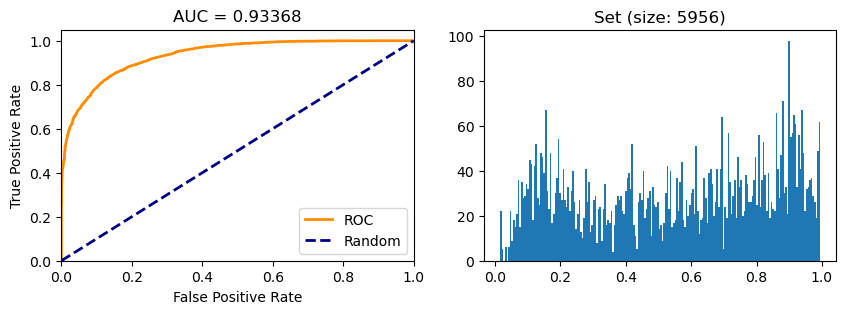

In [29]:
visualize_auc(y_train, y_train_pred)

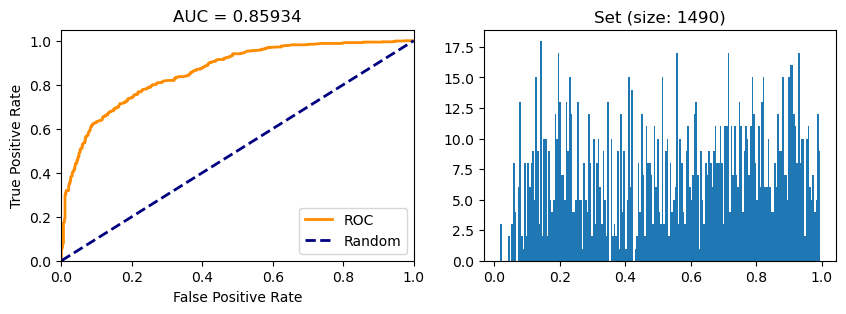

In [30]:
visualize_auc(y_val, y_val_pred)

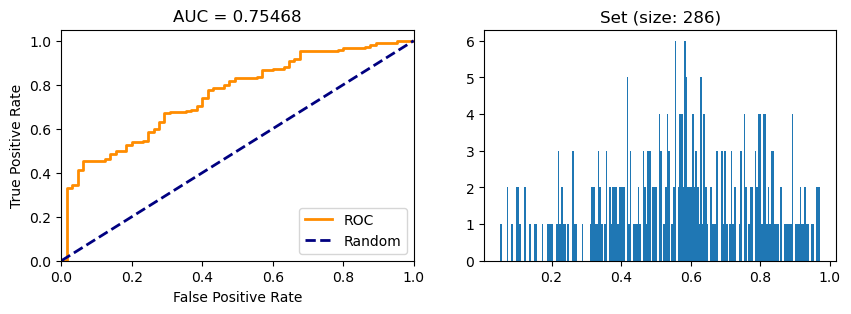

In [31]:
visualize_auc(y_test, y_test_pred)